# L1 norm prior experiment

This code attempts to learn the 8D prior
$J(x) = ||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i)$- using Huber function 

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/L1_prior_8D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Section 3.1: Convex Prior J(x) = ||x||_1
    # S(x,t) is the Moreau Envelope of the L1 norm (Huber function).
    # Per component j: if |x_j| > t: |x_j| - t/2. If |x_j| <= t: x_j^2 / 2t
    
    abs_y = np.abs(y)
    # Mask for |x| <= t
    small_mask = abs_y <= t
    
    # Component-wise values
    comps = np.zeros_like(y)
    comps[small_mask] = (abs_y[small_mask]**2) / (2 * t)
    comps[~small_mask] = abs_y[~small_mask] - (t / 2.0)
    
    # Sum across dimensions (separable)
    return np.sum(comps, axis=1)


def prior_true(y):
    # J(x) = ||x||_1
    return np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Convex functions(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Convex functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}")
        plt.xlabel('$x_1$')
        plt.ylabel('Prior functions ($0,x_2$,0)')
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 8

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 30000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 103.40076446533203
iteration 0 loss 965.6997680664062


iteration 5000 loss 0.2722708284854889


iteration 10000 loss 0.028031466528773308


iteration 15000 loss 0.011105407029390335


iteration 20000 loss 0.007676963694393635


iteration 25000 loss 0.005966637283563614


iteration 30000 loss 0.004872255027294159


iteration 35000 loss 0.00378094962798059


iteration 40000 loss 0.002825150266289711


iteration 45000 loss 0.0025901072658598423


iteration 50000 loss 0.0017440959345549345


iteration 55000 loss 0.001445943838916719


iteration 60000 loss 0.0012520597083494067


iteration 65000 loss 0.0010754282120615244


iteration 70000 loss 0.0009586110827513039


iteration 75000 loss 0.0008372088195756078


iteration 80000 loss 0.0007589705637656152


iteration 85000 loss 0.0006971961702220142


iteration 90000 loss 0.0006337533122859895


iteration 95000 loss 0.0006041977903805673


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.006846047006547451


iteration 105000 loss 0.0005412307800725102


iteration 110000 loss 0.0005132572259753942


iteration 115000 loss 0.0004932380397804081


iteration 120000 loss 0.00047386097139678895


iteration 125000 loss 0.00045594098628498614


iteration 130000 loss 0.00044053743476979434


iteration 135000 loss 0.00042541464790701866


iteration 140000 loss 0.00041217324906028807


iteration 145000 loss 0.000400006421841681


iteration 150000 loss 0.0003889052604790777


iteration 155000 loss 0.0003796977980528027


iteration 160000 loss 0.00036905560409650207


iteration 165000 loss 0.0003596060851123184


iteration 170000 loss 0.00035098218359053135


iteration 175000 loss 0.0003424274909775704


iteration 180000 loss 0.0003343286516610533


iteration 185000 loss 0.0003258318465668708


iteration 190000 loss 0.00031895554275251925


iteration 195000 loss 0.0003114518185611814


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.00030393493943847716


iteration 205000 loss 0.00030187066295184195


iteration 210000 loss 0.00029240603907965124


iteration 215000 loss 0.000282877532299608


iteration 220000 loss 0.00027327012503519654


iteration 225000 loss 0.0002651764953043312


iteration 230000 loss 0.00025672640185803175


iteration 235000 loss 0.00024907331680878997


iteration 240000 loss 0.0002412261674180627


iteration 245000 loss 0.00023442534438800067


iteration 250000 loss 0.00022808913490734994


iteration 255000 loss 0.00022240413818508387


iteration 260000 loss 0.00021685604588128626


iteration 265000 loss 0.00021166262740734965


iteration 270000 loss 0.0002062605053652078


iteration 275000 loss 0.000201346367248334


iteration 280000 loss 0.00019693603098858148


iteration 285000 loss 0.00019293186778668314


iteration 290000 loss 0.00018929688667412847


iteration 295000 loss 0.00018521475431043655


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.00018144390196539462


iteration 305000 loss 0.000180293049197644


iteration 310000 loss 0.00017632788512855768


iteration 315000 loss 0.00017245850176550448


iteration 320000 loss 0.00016878862516023219


iteration 325000 loss 0.0001652721839491278


iteration 330000 loss 0.00016189513553399593


iteration 335000 loss 0.00015864257875364274


iteration 340000 loss 0.00015550770331174135


iteration 345000 loss 0.00015248813724610955


iteration 350000 loss 0.00014958149404264987


iteration 355000 loss 0.00014680263120681047


iteration 360000 loss 0.00014413938333746046


iteration 365000 loss 0.0001415138685842976


iteration 370000 loss 0.000138969233375974


iteration 375000 loss 0.00013651634799316525


iteration 380000 loss 0.00013415298599284142


iteration 385000 loss 0.00013187086733523756


iteration 390000 loss 0.00012967629299964756


iteration 395000 loss 0.00012754923955071718


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.00012551085092127323


iteration 405000 loss 0.0001250977220479399


iteration 410000 loss 0.00012457856792025268


iteration 415000 loss 0.00012410264753270894


iteration 420000 loss 0.00012364292342681438


iteration 425000 loss 0.00012319280358497053


iteration 430000 loss 0.00012274819891899824


iteration 435000 loss 0.00012230852735228837


iteration 440000 loss 0.00012187221000203863


iteration 445000 loss 0.0001214397416333668


iteration 450000 loss 0.00012101108586648479


iteration 455000 loss 0.00012058653373969719


iteration 460000 loss 0.00012016566324746236


iteration 465000 loss 0.00011974784865742549


iteration 470000 loss 0.00011933264613617212


iteration 475000 loss 0.00011892060865648091


iteration 480000 loss 0.00011851138697238639


iteration 485000 loss 0.00011810462456196547


iteration 490000 loss 0.00011770000128308311


iteration 495000 loss 0.00011729769175872207


L2 loss -- Plot

loss 1.164180040359497


loss -101.91155242919922


loss -201.2525634765625


loss -288.1989440917969


loss -347.729736328125


loss -389.88311767578125


loss -420.2701110839844


loss -441.61822509765625


loss -456.2373352050781


loss -465.69281005859375


loss -471.6983337402344


loss -475.7747497558594


loss -478.9058532714844


loss -481.6380615234375


loss -484.2660827636719


loss -486.94830322265625


loss -489.76171875


loss -492.7311096191406


loss -495.849609375


loss -499.0948486328125


loss -502.4398193359375


loss -505.85919189453125


loss -509.33209228515625


loss -512.8422241210938


loss -516.37744140625


loss -519.9291381835938


loss -523.4910888671875


loss -527.0589599609375


loss -530.63037109375


loss -534.2034301757812


loss -537.7769775390625


loss -541.3499755859375


loss -544.922119140625


loss -548.492919921875


loss -552.062255859375


loss -555.6300659179688


loss -559.1962280273438


loss -562.7606201171875


loss -566.323486328125


loss -569.8848876953125


final mse:  0.004499220289289951
max, min: 18.07473 -18.063831
loss 1.164180040359497


loss -101.58540344238281


loss -200.98362731933594


loss -287.99920654296875


loss -347.54364013671875


loss -389.9796142578125


loss -420.2785339355469


loss -441.5477294921875


loss -456.20965576171875


loss -465.71563720703125


loss -471.5475769042969


loss -475.82537841796875


loss -479.7882080078125


loss -483.90728759765625


loss -488.33154296875


loss -493.0844421386719


loss -498.1346435546875


loss -503.4295349121094


loss -508.9131164550781


loss -514.5357055664062


loss -520.2571411132812


loss -526.0474853515625


loss -531.884765625


loss -537.7538452148438


loss -543.644287109375


loss -549.548828125


loss -555.4628295898438


loss -561.3823852539062


loss -567.304931640625


loss -573.2290649414062


loss -579.154052734375


loss -585.0794067382812


loss -591.0050048828125


loss -596.9314575195312


loss -602.8589477539062


loss -608.7869262695312


loss -614.7135009765625


loss -620.63818359375


loss -626.562744140625


loss -632.4871215820312


final mse:  0.009655202738940716
max, min: 18.378355 -18.403965


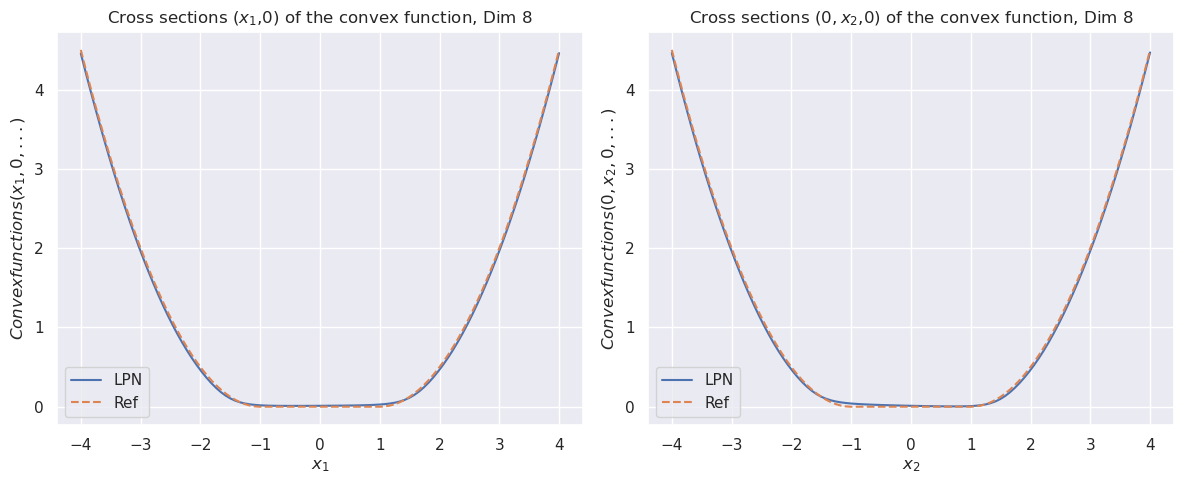

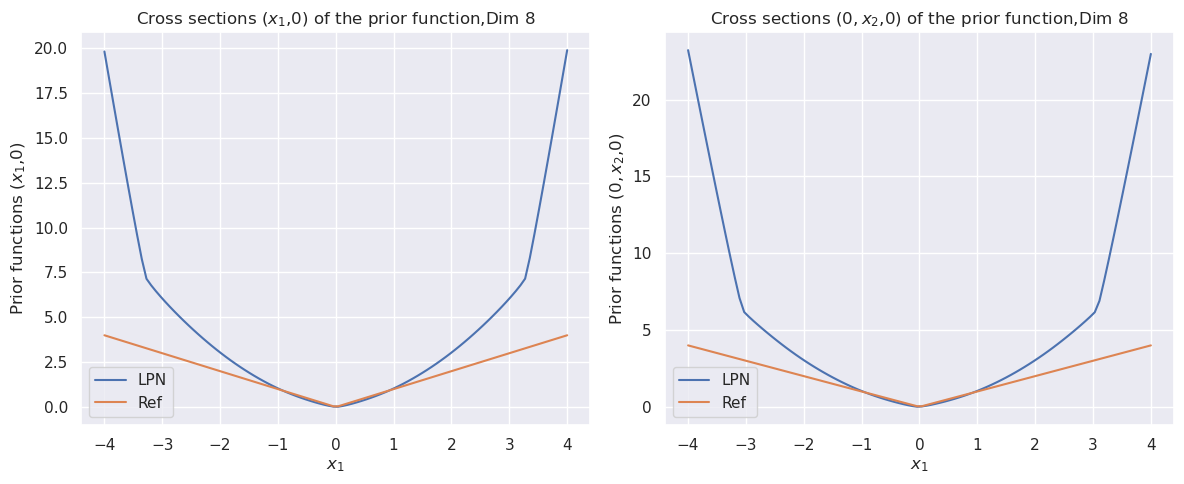

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 370.3616943359375
iteration 0 loss 75.76366424560547


iteration 5000 loss 0.03130117058753967


iteration 10000 loss 0.02343902550637722


iteration 15000 loss 0.019246339797973633


iteration 20000 loss 0.015619439072906971


iteration 25000 loss 0.0129464752972126


iteration 30000 loss 0.01114023569971323


iteration 35000 loss 0.009512964636087418


iteration 40000 loss 0.008458008989691734


iteration 45000 loss 0.007513534277677536


iteration 50000 loss 0.007145927287638187


iteration 55000 loss 0.006038071122020483


iteration 60000 loss 0.00545369042083621


iteration 65000 loss 0.004938491620123386


iteration 70000 loss 0.0047037540934979916


iteration 75000 loss 0.004344497341662645


iteration 80000 loss 0.3556479811668396


iteration 85000 loss 0.0034429144579917192


iteration 90000 loss 0.0033197763841599226


iteration 95000 loss 0.0029635359533131123


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.0027587225195020437


iteration 105000 loss 0.0026555738877505064


iteration 110000 loss 0.00252276798710227


iteration 115000 loss 0.006014193408191204


iteration 120000 loss 0.0023006461560726166


iteration 125000 loss 0.002212177962064743


iteration 130000 loss 0.0021315680351108313


iteration 135000 loss 0.002054966753348708


iteration 140000 loss 0.001984943635761738


iteration 145000 loss 0.001924065756611526


iteration 150000 loss 0.0018688380951061845


iteration 155000 loss 0.0018131246324628592


iteration 160000 loss 0.0017602312145754695


iteration 165000 loss 0.0017146867467090487


iteration 170000 loss 0.0016706946771591902


iteration 175000 loss 0.001625226577743888


iteration 180000 loss 0.0015876108082011342


iteration 185000 loss 0.001550409710034728


iteration 190000 loss 0.0015135247958824039


iteration 195000 loss 0.0014784150989726186


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.001446863287128508


iteration 205000 loss 0.0014344227965921164


iteration 210000 loss 0.001401238958351314


iteration 215000 loss 0.001368739060126245


iteration 220000 loss 0.0013401361647993326


iteration 225000 loss 0.0013110974105075002


iteration 230000 loss 0.0012813480570912361


iteration 235000 loss 0.001253882423043251


iteration 240000 loss 0.0012297492939978838


iteration 245000 loss 0.0012015614192932844


iteration 250000 loss 0.0011756978929042816


iteration 255000 loss 0.0011513370554894209


iteration 260000 loss 0.0011313861468806863


iteration 265000 loss 0.001108319265767932


iteration 270000 loss 0.0010882060742005706


iteration 275000 loss 0.001067865639925003


iteration 280000 loss 0.0010478018084540963


iteration 285000 loss 0.0010299041168764234


iteration 290000 loss 0.0010102094383910298


iteration 295000 loss 0.000993845285847783


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.000976473034825176


iteration 305000 loss 0.0009725760901346803


iteration 310000 loss 0.0009581941412761807


iteration 315000 loss 0.0009427228942513466


iteration 320000 loss 0.000927839835640043


iteration 325000 loss 0.0009134534629993141


iteration 330000 loss 0.0008992203511297703


iteration 335000 loss 0.0008853435283526778


iteration 340000 loss 0.0008718154858797789


iteration 345000 loss 0.0008586021140217781


iteration 350000 loss 0.0008457822841592133


iteration 355000 loss 0.0008332378347404301


iteration 360000 loss 0.0008208880899474025


iteration 365000 loss 0.0008085977169685066


iteration 370000 loss 0.0007966189878061414


iteration 375000 loss 0.0007850780966691673


iteration 380000 loss 0.0007739125285297632


iteration 385000 loss 0.00076312042074278


iteration 390000 loss 0.0007526948465965688


iteration 395000 loss 0.0007424936047755182


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.0007326046470552683


iteration 405000 loss 0.0007313056848943233


iteration 410000 loss 0.000729561026673764


iteration 415000 loss 0.0007278549019247293


iteration 420000 loss 0.0007261767168529332


iteration 425000 loss 0.0007245206506922841


iteration 430000 loss 0.0007228833273984492


iteration 435000 loss 0.0007212623604573309


iteration 440000 loss 0.0007196538499556482


iteration 445000 loss 0.0007180614047683775


iteration 450000 loss 0.0007164806011132896


iteration 455000 loss 0.0007149108569137752


iteration 460000 loss 0.0007133513572625816


iteration 465000 loss 0.0007118011126294732


iteration 470000 loss 0.0007102614035829902


iteration 475000 loss 0.0007087316480465233


iteration 480000 loss 0.0007072088192217052


iteration 485000 loss 0.0007057070033624768


iteration 490000 loss 0.0007042200304567814


iteration 495000 loss 0.0007027410320006311


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


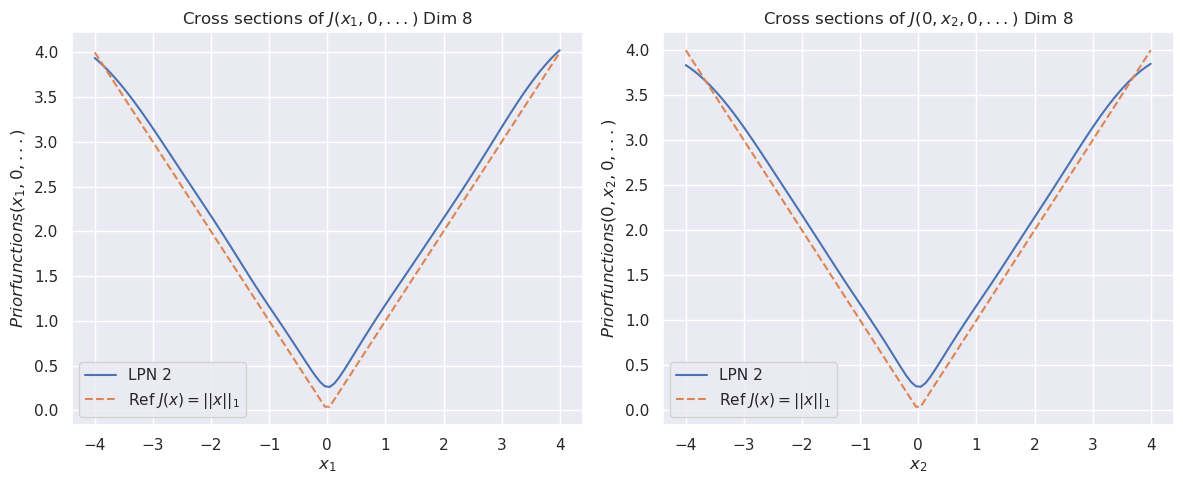

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)